In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical

### Generate State Space

The state space is 2-dimensional, consisting of `num_concepts` different classes. Class $c_i$ is generated by sampling from a normal distribution $~\mathcal{N}(\mu_{c_i}, \sigma_{c_i})$. The concept of a class is assumed to be its mean $\mu_{c_i}$.

In [2]:
num_concepts = 5
examples_per_concept = 100

(500, 2)


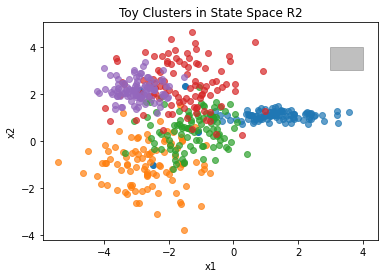

In [50]:
# Sample candidate class means from uniform distribution
x1 = np.random.uniform(-3, 3, num_concepts)
x2 = np.random.uniform(-3, 3, num_concepts)
means = np.stack((x1, x2), axis=1)

fig, ax = plt.subplots()
plt.scatter(x1, x2)

clusters = np.zeros((examples_per_concept*num_concepts, 2))
y = np.zeros(examples_per_concept*num_concepts)

for i in range(num_concepts):
    y[i*examples_per_concept: (i+1)*examples_per_concept] = i
    cov = [[np.random.uniform(0.01, 1), 0], [0, np.random.uniform(0.01, 1)]]
    x1, x2 = np.random.multivariate_normal(
        means[i], cov, size=examples_per_concept, check_valid='warn').T
    clusters[i*examples_per_concept: (i+1)*examples_per_concept] = np.stack((x1,x2), axis=1)
    plt.plot(x1, x2, 'o', alpha=0.7)

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax.add_patch(rect)
print(clusters.shape)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy Clusters in State Space R2")
plt.show()


In [3]:
def save_dataset_and_trajectories(filename, centroids, clusters, trajectories, rewards, unique_concepts, concepts, actions):
    np.savez(filename, centroids=centroids, clusters=clusters, trajectories=np.array(trajectories,
             dtype=object), rewards=np.array(rewards), unique_concepts=np.array(unique_concepts, dtype=object), concepts=np.array(concepts, dtype=object), actions=np.array(actions, dtype=object))


def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']
    


from sklearn.neighbors import KNeighborsClassifier
import numpy as np
means, clusters, _, _, _, _, _ = load_dataset_and_trajectories("dataset_large.npz")

# Load some example data
X_train = np.array(clusters)
y_train = np.repeat(np.array([0,1,2,3,4]),100)
X_test = np.array([[1,1], [3,3],[0,-2]])

# Create a kNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=3) #smaller k values results in more fluctuation of the concepts

# Train the classifier
knn.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = knn.predict(X_test)

# Print the predicted labels
print(y_pred)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
[3 0 4]


### Environment Dynamics

Suppose the goal of the agent is to reach the upper right corner our confined state space, a square located at (3,3). Let the reward of of all steps in which the goal is not achieved by -1. Additionally, suppose there is a $\textit{wind}$ acting in the negative $x$ direction, pushing the agent further from its goal. Suppose also that the agent experiences the wind more severely in certain regions of the state space; characterised by the concept classes in the dataset.

Let the action space comprise of 4 discrete actions: {up, down, right, left}

The transtition to the next state $T(s'|s)$ is given as
$ s_{t+1} = s_{t} + \Delta_{ss} \cdot a_t + w(s_t) $,
Where $\Delta_{ss}$ is a step size, $a_t$ is a unit vector representing the action and $w(s_t)$ is a function which describes the $\textit{wind severity experienced by the agent}$ given the current state. Intuitively, we may want to avoid certain states in reaching our goal, or at least know if taking some action might lead to problematic states.

A possible definition of $w(s_t)$. The severity of the $\textit{wind}$ in each cluster may be normally distributed around the center of the cluster, i.e. focused at the center. Then the severity for a given position in the state space could be represented by the sum severities sampled from each distribution weighted by the distance to the cluster centroid.

### Generate Trajectories and Behaviour Policy

During trajectory generation, we can assign a state to a concept/cluster possibly by its K nearest neighbours, or simply to the class of its closest centroid. Then for each time step in a trajectory, we will have a tuple $(s_i, a_i, r_{i+1}, c_i)$.

* How to define a behaviour policy? Example: Starting in the bottom right corner, move up and right with greater and probability of moving left and down respectively.

In [4]:
means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("dataset_large.npz")
print(np.array(trajectories, dtype=object).shape)
print(np.array(rewards).shape)
print(np.array(unique_concepts, dtype=object).shape)
print(np.array(concepts, dtype=object).shape)
print(np.array(actions, dtype=object).shape)
print(means.shape)
print(clusters.shape)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(653,)
(653,)
(653,)
(653,)
(653,)
(5, 2)
(500, 2)


In [5]:
from gridworld.environment import WindyGridworld

num_concepts = 5
env = WindyGridworld(num_concepts=num_concepts, method="simple", knn=knn, means=means, policy_model=None)

trajectories = []
rewards = []
unique_concepts = []
concepts = []
actions = []


# Create dataset in windy gridworld
for j in tqdm(range(100)):
    env.play(True, trajectories, rewards, unique_concepts, concepts, actions)


## Save Dataset and Trajectory Information

In [63]:
filename = "dataset_knn_temp"
save_dataset_and_trajectories(filename=filename, centroids=means, clusters=clusters, trajectories=trajectories,
                              rewards=rewards, unique_concepts=unique_concepts, concepts=concepts, actions=actions)

In [64]:
means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("dataset_knn.npz")
print(np.array(trajectories, dtype=object).shape)
print(np.array(rewards).shape)
print(np.array(unique_concepts, dtype=object).shape)
print(np.array(concepts, dtype=object).shape)
print(np.array(actions, dtype=object).shape)
print(means.shape)
print(clusters.shape)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(627,)
(627,)
(627,)
(627,)
(627,)
(5, 2)
(500, 2)


45


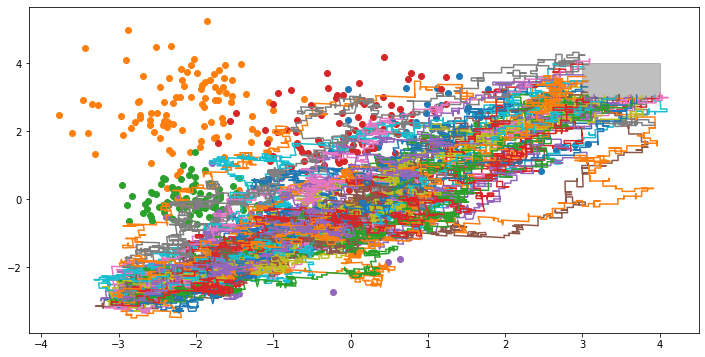

In [16]:
#Visualise all trajectories
fig, ax2 = plt.subplots(figsize=(12,6))
N = 0
for history in trajectories:
    N += len(history)
    plt.plot(history[:, 0], history[:, 1], label="Trajectory")
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*examples_per_concept
    end = (i+1)*examples_per_concept
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

# plt.legend()
plt.show()

Reward: -678


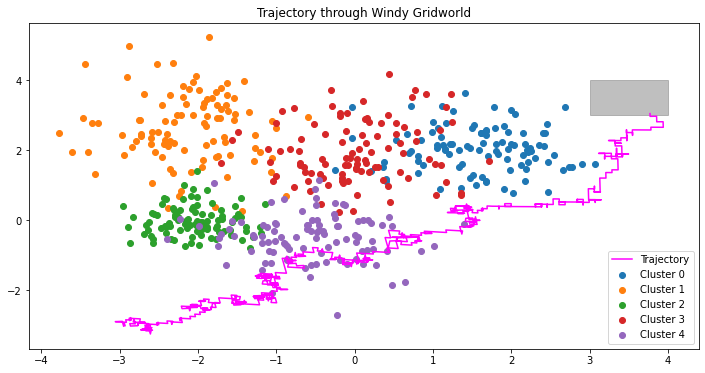

627


In [66]:
fig, ax2 = plt.subplots(figsize=(12,6))
index = np.random.randint(0,len(trajectories))
history = np.array(trajectories[index])
# print(f"Concepts visited: {concepts[index]}")
print(f"Reward: {rewards[index]}")
plt.plot(history[:, 0], history[:, 1], color="magenta", label="Trajectory")
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*examples_per_concept
    end = (i+1)*examples_per_concept
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

print(len(trajectories))

In [67]:
unique_concept_combinations_visited = []

for comb in unique_concepts:
    if comb not in unique_concept_combinations_visited:
        unique_concept_combinations_visited.append(comb)
print(f"Number of unique concept combinations visited {len(unique_concept_combinations_visited)}")
mean_reward_per_combination = np.zeros(len(unique_concept_combinations_visited))
combination_occurence = np.zeros(len(unique_concept_combinations_visited))

for i,r in enumerate(rewards):
    comb = unique_concepts[i]
    unique_comb_index = unique_concept_combinations_visited.index(comb)
    mean_reward_per_combination[unique_comb_index] += r
    combination_occurence[unique_comb_index] += 1


mean_reward_per_combination = mean_reward_per_combination/combination_occurence
for i,c in enumerate(unique_concept_combinations_visited):
    print(f"Concepts {c} have mean reward {mean_reward_per_combination[i]}")

#~50k trajectories
# Store s,a,s',r,c for every time step for each trajectory
# learn behaviour policy to get pi_b (NN to learn this. Output action, input states-summary|concepts. over states and actions (usual) or over states and concepts
# then find ratios of pi_e/pi_b 

Number of unique concept combinations visited 6
Concepts [0, 2, 3, 4] have mean reward -655.196875
Concepts [0, 1, 2, 3, 4] have mean reward -623.4666666666667
Concepts [0, 3, 4] have mean reward -671.8174603174604
Concepts [0, 1, 3, 4] have mean reward -705.7142857142857
Concepts [0, 2, 4] have mean reward -751.25
Concepts [0, 4] have mean reward -738.8333333333334


## Prepare Dataset
The regions visited in the state space and concepts in a trajectory need to be summarised into some feature of consistent size, such that they can be input into a neuaral network in order to learn $\pi_b$. The output of the network should be a softmax over actions.

A training sample should take one of the following forms depending on the approach:

* $(a | \hat{s}_x, \hat{s}_y)$ where $\hat{s}$ is the average state over in a previous window of size $W_s$.
* $(\bar{a} | \hat{s}_x, \hat{s}_y)$ where $\bar{a}$ is the most frequent action taken in a previous window of size $W_a$
* $(a | \hat{s}_x, \hat{s}_y, c)$ where c is the concept assigned in each state
* $(\bar{a} | \hat{s}_x, \hat{s}_y, c)$ 



In [447]:
W_s = 10
W_a = 10

training_samples = []


def generate_dataset_windowed_states(trajectories):
    windowed_trajectories = [] # np.array((len(trajectories),2))
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj),2))
        for i in range(1,len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')


def generate_dataset_windowed_states_and_actions():
    pass

def generate_dataset_windowed_states_concepts():
    pass

def generate_dataset_windowed_states_and_actions_concepts():
    pass


In [448]:
Y = np.concatenate(np.array(actions, dtype='object'))
X = np.concatenate(generate_dataset_windowed_states(trajectories))
Y_categorical = np.zeros(len(Y))
print(X.shape)
print(Y.shape)
for i in range(len(Y)):
    if (Y[i] == np.array(A[0])).all():
        Y_categorical[i] = 0
    elif (Y[i] == np.array(A[1])).all():
        Y_categorical[i] = 1
    elif (Y[i] == np.array(A[2])).all():
        Y_categorical[i] = 2
    else:
        Y_categorical[i] = 3


(255320, 2)
(254831, 2)


In [385]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[0:len(Y_categorical)], Y_categorical, test_size=0.2)


In [386]:
model = Sequential()
model.add(Dense(32, activation="relu", input_shape=X_train[0].shape))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, to_categorical(y_train,4), epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

Epoch 1/10
5157/5157 [==============================] - 8s 2ms/step - loss: 1.3052 - categorical_accuracy: 0.3527 - val_loss: 1.3051 - val_categorical_accuracy: 0.3508
Epoch 2/10
5157/5157 [==============================] - 7s 1ms/step - loss: 1.3029 - categorical_accuracy: 0.3525 - val_loss: 1.3049 - val_categorical_accuracy: 0.3496
Epoch 3/10
5157/5157 [==============================] - 7s 1ms/step - loss: 1.3025 - categorical_accuracy: 0.3547 - val_loss: 1.3052 - val_categorical_accuracy: 0.3477
Epoch 4/10
5157/5157 [==============================] - 8s 2ms/step - loss: 1.3025 - categorical_accuracy: 0.3544 - val_loss: 1.3045 - val_categorical_accuracy: 0.3505
Epoch 5/10
5157/5157 [==============================] - 8s 2ms/step - loss: 1.3024 - categorical_accuracy: 0.3522 - val_loss: 1.3051 - val_categorical_accuracy: 0.3510
Epoch 6/10
5157/5157 [==============================] - 8s 2ms/step - loss: 1.3024 - categorical_accuracy: 0.3522 - val_loss: 1.3046 - val_categorical_accuracy:

In [387]:
print(X_test.shape)
print(y_test.shape)
score = model.evaluate(X_test, to_categorical(y_test,4))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(51567, 2)
(51567,)
1612/1612 [==============================] - 2s 1ms/step - loss: 1.3044 - categorical_accuracy: 0.3537
Test loss: 1.304389476776123
Test accuracy: 0.35369518399238586


## Train NN to Learn $\pi_b$

In [15]:
class GridWorldAgent:
    '''GridWorldAgent class implementing a NN to learn the behavioural policy implicit to the generated windy gridworld dataset'''

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.gamma = 0.9995    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):  # We implement the epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def exploit(self, state):  # When we test the agent we dont want it to explore anymore, but to exploit what it has learnt
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)

        state_b = np.squeeze(np.array(list(map(lambda x: x[0], minibatch))))
        action_b = np.squeeze(np.array(list(map(lambda x: x[1], minibatch))))
        reward_b = np.squeeze(np.array(list(map(lambda x: x[2], minibatch))))
        next_state_b = np.squeeze(
            np.array(list(map(lambda x: x[3], minibatch))))
        done_b = np.squeeze(np.array(list(map(lambda x: x[4], minibatch))))

        target = (reward_b + self.gamma *
                  np.amax(self.model.predict(next_state_b), 1))

        target[done_b == 1] = reward_b[done_b == 1]
        target_f = self.model.predict(state_b)
        for k in range(target_f.shape[0]):
            target_f[k][action_b[k]] = target[k]
        self.model.train_on_batch(state_b, target_f)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [660]:
EPISODES = 30

state_size = 2 #2D coordinates
action_size = 4 #up, down, right, left
agent = DQNAgent(state_size, action_size)
done = False
batch_size = 32
reward = 0
episode_reward_list = deque(maxlen=50)
agent.memory.clear()
goal = np.array([3,3])

for e in range(EPISODES):
    #generate state randomly instead
    cov = [[np.random.uniform(0.01, 1), 0], [0, np.random.uniform(0.01, 1)]]
    x1, x2 = np.random.multivariate_normal(
        [-4,0], cov, check_valid='warn').T
    state = np.array([x1,x2])
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    for time in range(100):
        distance1 = np.linalg.norm(goal-state[0])
        action_index = agent.act(state)
        action = A[action_index]

        wind_value, severity = wind(state, means)
        
        next_state = state + 0.5*action + 0.1*wind_value  # transition
        done = reached_goal(next_state)
        distance2 = np.linalg.norm(goal-next_state[0])
        
        if (distance2-distance1) < 0: #whatever action we took took us closer to our goal
            reward = 0.0
        else:
            reward = -1.0

        if done:
            reward += 10
        # reward -= severity*10

        # if action_index == 0 or action_index == 2: #encourage moving up and right
        #          reward += 0.75
   
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action_index, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, time, agent.epsilon))
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    episode_reward_list.append(total_reward)
    episode_reward_avg = np.array(episode_reward_list).mean()
    print("episode: {}/{}, score: {}, e: {:.2}, last 50 ep. avg. rew.: {:.2f}"
                  .format(e, EPISODES, total_reward, agent.epsilon, episode_reward_avg)) 

episode: 0/30, score: -48.0, e: 0.71, last 50 ep. avg. rew.: -48.00
episode: 1/30, score: -43.0, e: 0.43, last 50 ep. avg. rew.: -45.50
episode: 2/30, score: -35.0, e: 0.26, last 50 ep. avg. rew.: -42.00
episode: 3/30, score: -37.0, e: 0.16, last 50 ep. avg. rew.: -40.75
episode: 4/30, score: -38.0, e: 0.096, last 50 ep. avg. rew.: -40.20
episode: 5/30, score: -39.0, e: 0.058, last 50 ep. avg. rew.: -40.00
episode: 6/30, score: 40, e: 0.047
episode: 6/30, score: -1.0, e: 0.047, last 50 ep. avg. rew.: -34.43


KeyboardInterrupt: 

In [661]:
#Load or Save Agent
save = True
load = False
if save:
    agent.save("latest_trained_agent")
if load:
    state_size = 2 #2D coordinates
    action_size = 4 #up, down, right, left
    agent = DQNAgent(state_size, action_size)
    agent.load("latest_trained_agent")
    

71
-11.0


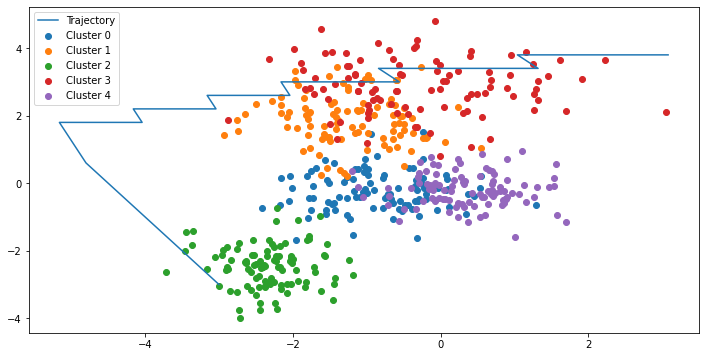

In [666]:
s = np.array([-3,-3])
history = []
history.append(s)

state_size = 2 #2D coordinates
action_size = 4 #up, down, right, left

agent.epsilon = 0.01
goal = [3,3]
total_reward = 0
for t in range(100):
    s = np.reshape(s, [1, 2])
    distance1 = np.linalg.norm(goal-s[0])
    action = agent.act(s)
    wind_value, severity = wind(s, means)
    s = s + 0.4*(A[action] + wind_value)  # transition
    distance2 = np.linalg.norm(goal-s[0])
    history.append(s[0])
    if reached_goal(s):
        print(t)
        break
    if (distance2-distance1) < 0: #whatever action we took took us closer to our goal
            reward = 0.0
    else:
            reward = -1.0
    # reward -= severity*4
    total_reward+=reward
    

print(total_reward)
history = np.array(history)
fig = plt.figure(figsize=(12,6))
plt.plot(history[:, 0], history[:, 1], label="Trajectory")
for i in range(num_concepts):
    start = i*examples_per_concept
    end = (i+1)*examples_per_concept
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.show()